## Potential Talents - Part 1

----

### Part 1: EDA + TF-IDF + Cosine Search

**Objective.**  
Explore and prepare the **job title** corpus, build a transparent **TF-IDF** representation (manual + scikit-learn), and validate a simple **cosine-similarity** search for queries like “Data Scientist.”

**Data & Prep.**  
- Load `potential_talents.csv`.  
- Tokenize, lowercase, remove **stopwords** and **punctuation** (NLTK).  
- Inspect vocabulary and frequencies; visualize with **WordCloud** and **Top-N bar chart**.  
- Detect duplicates via **cosine similarity heatmaps** and `value_counts()`.

**Method (steps).**
1) **EDA**: dataset info, token stats, frequency analysis.  
2) **Visualizations**: WordCloud + bar chart of most frequent terms.  
3) **TF-IDF (from scratch)**: compute TF, IDF, and TF-IDF. Then align with **scikit-learn** using **smoothing** (`log((1+N)/(1+df))+1`) and **L2 normalization**.  
4) **Cosine Similarity Search**: rank titles by similarity to a query (manual matrix ops and scikit-learn) and compare results for parity.

**Key result.**  
After smoothing + L2 norm, the **manual TF-IDF matches scikit-learn closely**, confirming correctness. The **cosine-based search** returns sensible neighbors for “Data Scientist,” with duplicates made visible in the similarity plots—useful signals for later cleaning and model steps.


----


### 1. EDA

In [10]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv('./data/potential_talents.csv')

In [12]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [ ]:
import nltk

#### Tokenize each word of the 'job title' column

In [ ]:
job_title_treated = [nltk.tokenize.word_tokenize(title, language='english') for title in df ['job_title']]
print(f'Number of tokenized job titles rows: {len(job_title_treated)}')

Number of tokenized job titles rows: 104


In [16]:
for job_title in job_title_treated[:5]:
    print(job_title)

['2019', 'C.T', '.', 'Bauer', 'College', 'of', 'Business', 'Graduate', '(', 'Magna', 'Cum', 'Laude', ')', 'and', 'aspiring', 'Human', 'Resources', 'professional']
['Native', 'English', 'Teacher', 'at', 'EPIK', '(', 'English', 'Program', 'in', 'Korea', ')']
['Aspiring', 'Human', 'Resources', 'Professional']
['People', 'Development', 'Coordinator', 'at', 'Ryan']
['Advisory', 'Board', 'Member', 'at', 'Celal', 'Bayar', 'University']


#### Lower each token and reduce one dimension of the list

In [17]:
job_title_treated = [ token.lower() for tokens in job_title_treated for token in tokens]
print(f'Number of tokens in all the document: {len(job_title_treated)}')

Number of tokens in all the document: 876


In [18]:
for job_title in job_title_treated[:10]:
    print(job_title, end=", ")

2019, c.t, ., bauer, college, of, business, graduate, (, magna, 

#### Count the frequency of each word

In [19]:
from collections import Counter

In [20]:
freq_map = Counter(job_title_treated)

In [ ]:
for word, freq in freq_map.most_common(20):
    print(f"{word}: {freq}")

human: 63
resources: 62
at: 46
aspiring: 35
and: 28
|: 28
professional: 20
,: 19
student: 16
.: 15
seeking: 15
college: 14
(: 14
): 14
generalist: 14
university: 12
specialist: 12
of: 11
business: 11
english: 10


We observe some punctuation and stop words, therefore we will filter them.

#### Filter the stop words and the puntiation

In [22]:
from nltk.corpus import stopwords
import string

In [ ]:
stop_words = set(stopwords.words("english"))
punctuations = set(string.punctuation)

In [24]:
# print the first 10 stop words
print('Stop words (first 10): \n\t',end="")
for stop_word in list(stop_words)[:10]:
    print(stop_word, end=", ")
print(f'...\nsize: {len(stop_words)}\n')

# print the first 10 punctiations
print('Punctiations (first 10): \n\t',end="")
for punctuation in list(punctuations)[:10]:
    print(punctuation, end=", ")
print(f'...\nsize: {len(punctuations)}')

Stop words (first 10): 
	themselves, shouldn, there, having, at, won, my, then, you, off, ...
size: 179

Punctiations (first 10): 
	^, ], +, /, >, |, ", `, ., ), ...
size: 32


In [25]:
job_title_clean = [ t for t in job_title_treated if t not in stop_words and t not in punctuations]

In [26]:
freq_map_clean = Counter(job_title_clean)

In [27]:
freq_map_size = len(freq_map)
freq_map_clean_size = len(freq_map_clean)
print(f'Vocab:\t\t\t\tSize:')
print(f' w/stop words and punctuation\t {freq_map_size}')
print(f' clean\t\t\t\t {freq_map_clean_size} ({((freq_map_size - freq_map_clean_size)/freq_map_size)*100:.0f}% reduction)')

Vocab:				Size:
 w/stop words and punctuation	 209
 clean				 185 (11% reduction)


### 2. Visualizations

In [28]:
freq_df = pd.DataFrame(freq_map_clean.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
freq_df.head(20)

,word,frequency
10,human,63
11,resources,62
9,aspiring,35
12,professional,20
30,student,16
35,seeking,15
32,generalist,14
3,college,14
28,university,12
29,specialist,12


In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

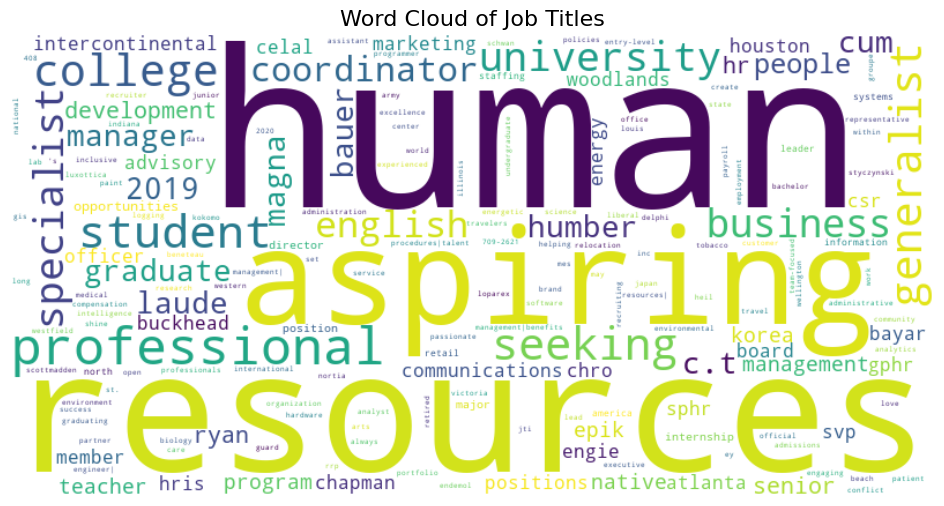

In [30]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_map_clean)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Job Titles", fontsize=16)
plt.show()

In [31]:
import seaborn as sns

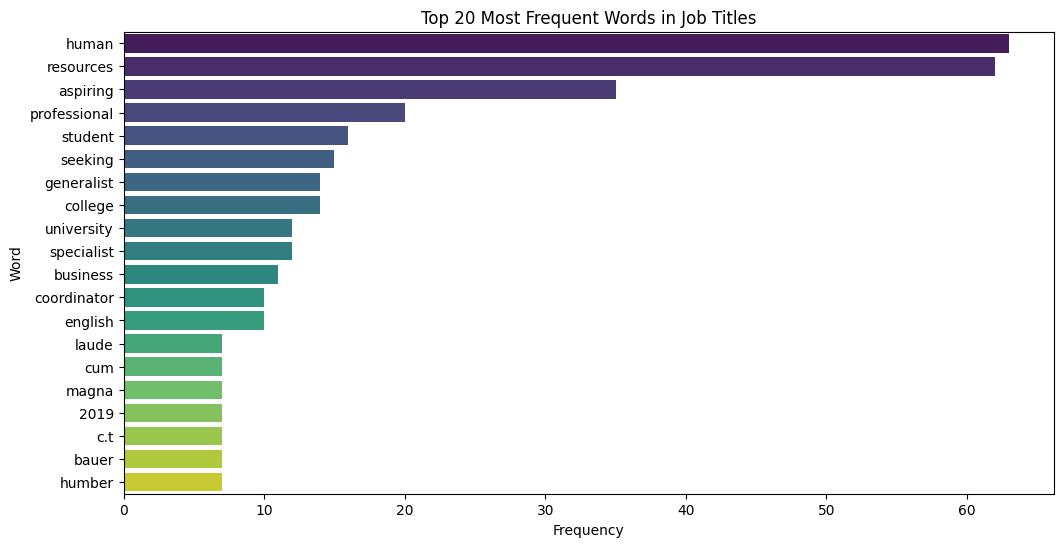

In [32]:
top_n = 20
plt.figure(figsize=(12, 6))
sns.barplot(data=freq_df.head(top_n), x='frequency', y='word', hue='word', palette='viridis', legend=False)
plt.title(f'Top {top_n} Most Frequent Words in Job Titles')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

### 3. Use TF-IDF for Feature Extraction

First, we will calculate the TF-IDF matrix from scratch and then we will compare results with built-in functions from ML libs.

#### 3.1 Numerical calculation (not using ML libs)

In [33]:
# First, tokenize the word of each job title keeping the rows
job_title_treated = [nltk.tokenize.word_tokenize(title, language='english') for title in df ['job_title']]
job_title_treated = [[word.lower() for word in job_title] for job_title in job_title_treated]


In [34]:
# purge stop words and puctuation
job_title_clean = [[t for t in job_title if t not in stop_words and t not in punctuations] for job_title in job_title_treated]


In [35]:
vocab = sorted(list(set([token for job_title in job_title_clean for token in job_title])))

In [36]:
len(vocab)

185

#### Calculate TF (Term Frequency):
TF = Number of times a word appeas / Number of total terms in Document

In [41]:
df_tf = np.zeros((df.shape[0], len(vocab)), dtype=float)

In [42]:
word_to_index = {word: idx for idx, word in enumerate(vocab)}

for i, job_title in enumerate(job_title_clean):
    job_title_len = len(job_title)
    word_counts = Counter(job_title)
    
    for word, count in word_counts.items():
        if word in word_to_index:
            df_tf[i][word_to_index[word]] = count / job_title_len
            

In [46]:
df_tf = pd.DataFrame(df_tf, columns=vocab)
df_tf.head()

,'s,2019,2020,408,709-2621,administration,administrative,admissions,advisory,always,...,undergraduate,university,victoria,wellington,western,westfield,within,woodlands,work,world
0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,...,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Calculate IDF (Inverse Document Frequency):
IDF = log ( Number of Documents in the corpus / Number of documents that include the word)

In [63]:
nb_of_Docs = df_tf.shape[0]
nb_of_Docs_per_word = np.zeros(df_tf.shape[1],dtype=float)

In [64]:
for i, job_title in enumerate(job_title_clean):
    word_counts = Counter(job_title)
    
    for word in word_counts.keys():
        if word in word_to_index:
            nb_of_Docs_per_word[word_to_index[word]] += 1

In [69]:
df_idf = np.log(nb_of_Docs/nb_of_Docs_per_word)
df_idf

array([4.6443909 , 2.69848075, 4.6443909 , 4.6443909 , 4.6443909 ,
       4.6443909 , 4.6443909 , 4.6443909 , 3.25809654, 4.6443909 ,
       3.95124372, 4.6443909 , 4.6443909 , 4.6443909 , 4.6443909 ,
       1.08904284, 4.6443909 , 3.25809654, 4.6443909 , 2.69848075,
       3.25809654, 4.6443909 , 4.6443909 , 4.6443909 , 3.25809654,
       4.6443909 , 3.25809654, 2.24649563, 2.69848075, 4.6443909 ,
       3.25809654, 4.6443909 , 3.25809654, 3.25809654, 2.00533357,
       3.25809654, 4.6443909 , 4.6443909 , 4.6443909 , 2.34180581,
       4.6443909 , 3.25809654, 2.69848075, 4.6443909 , 4.6443909 ,
       4.6443909 , 2.85263143, 3.54577861, 4.6443909 , 4.6443909 ,
       4.6443909 , 3.25809654, 4.6443909 , 3.25809654, 4.6443909 ,
       3.03495299, 4.6443909 , 4.6443909 , 4.6443909 , 3.03495299,
       4.6443909 , 4.6443909 , 4.6443909 , 4.6443909 , 2.00533357,
       4.6443909 , 3.25809654, 2.69848075, 4.6443909 , 4.6443909 ,
       4.6443909 , 4.6443909 , 4.6443909 , 4.6443909 , 3.25809

In [76]:
# tf-idf calculation
df_tfidf = df_tf * df_idf

#### 3.2 TF-IDF Calculation using Scikit-Learn

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [91]:
job_title_clean_str = [' '.join(tokens) for tokens in job_title_clean]
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=None,                # done
    tokenizer=lambda x: x.split(),  # already pre-tokenized
    smooth_idf=True,                # default: add smoothing
    use_idf=True,
    norm='l2'                       # normalize rows to unit length                
)


In [92]:
# Fit and transform
X_tfidf = vectorizer.fit_transform(job_title_clean_str)
# Convert to DF for comparison
df_tfidf_sklearn = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf_sklearn.head()

e:\Devs\pyEnv-1\venvs\Pot-Tals_env\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,'s,2019,2020,408,709-2621,administration,administrative,admissions,advisory,always,...,undergraduate,university,victoria,wellington,western,westfield,within,woodlands,work,world
0,0.0,0.32104,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.423208,0.0,...,0.0,0.323226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
np.linalg.norm(df_tfidf_sklearn.iloc[0])

np.float64(1.0)

We checked that the L2 norm from the first vetor is 1.0, as expected.

#### 3.3 Compare TF-IDF manual calculation with Scikit-Learn

In [98]:
# Align vocab to make sure both dataframes have same columns
common_columns = df_tfidf.columns.intersection(df_tfidf_sklearn.columns)
print(f'Manual TF-IDF vocab size:\t\t{len(df_tfidf.columns)}\nSklearn TF-IDF vocab size:\t\t{len(df_tfidf_sklearn.columns)}\nCommon vocab size:\t\t\t{len(common_columns)}')

Manual TF-IDF vocab size:		185
Sklearn TF-IDF vocab size:		185
Common vocab size:			185


In [99]:
comparison = df_tfidf[common_columns].subtract(df_tfidf_sklearn[common_columns])
comparison.abs().mean().sort_values(ascending=False).head(10)

human           0.080531
resources       0.079802
aspiring        0.050953
professional    0.027592
student         0.026826
specialist      0.019704
hr              0.017703
college         0.017039
senior          0.016818
chapman         0.015036
dtype: float64

#### 3.4 Adjust manual TF-IDF to match Scikit-Learn calculation

##### Original Manual IDF Formula (without smoothing)

$$
\text{idf}(t) = \log\left(\frac{N}{\text{df}(t)}\right)
$$

-  N : Total number of documents  
-  df(t) : Number of documents containing term \( t \)  
- No smoothing or offset

##### Adjusted IDF Formula (Scikit-learn Standard)

$$
\text{idf}(t) = \log\left(\frac{1 + N}{1 + \text{df}(t)}\right) + 1
$$

- Adds 1 to numerator and denominator (Laplace smoothing)
- Adds 1 to the final result to prevent zero division or zero weight

This adjustment helps ensure more stable and robust IDF scores, especially when a word appears in nearly all documents or very few.


In [105]:
# Apply the IDF Formula following the Scikit-Learn calculation
df_idf_smoothed = np.log((1 + nb_of_Docs) / (1 + nb_of_Docs_per_word)) + 1

In [106]:
# Calculat the new TF-IDF matrix
df_tfidf_smoothed = df_tf.multiply(df_idf_smoothed, axis=1)


In [107]:
# Normalize each vector with its L2 norm
df_tfidf_smoothed_normalized = df_tfidf_smoothed.div(np.linalg.norm(df_tfidf_smoothed, axis=1), axis=0)


#### Compare updated calculations (smoothing + L2 Norm) with Scikit-Learn

In [104]:
common_columns = df_tfidf_smoothed_normalized.columns.intersection(df_tfidf_sklearn.columns)
comparison_final = df_tfidf_smoothed_normalized[common_columns].subtract(df_tfidf_sklearn[common_columns])
comparison_final.abs().mean().sort_values(ascending=False).head(10)


specialist    1.654659e-17
aspiring      1.120898e-17
resources     7.606095e-18
humber        7.472655e-18
hr            5.871372e-18
human         5.604491e-18
english       5.337611e-18
senior        5.337611e-18
university    4.803850e-18
hris          4.270089e-18
dtype: float64

### Conclusion

After applying smoothing and normalization, our manual TF-IDF implementation closely matches Scikit-learn's `TfidfVectorizer` output. Minor numerical differences are due to floating point precision, confirming that our understanding and implementation of TF-IDF are correct and aligned with standard practice.


#### 3.5 Visualizations

#### 3.5.1 Histogram of TF-IDF values

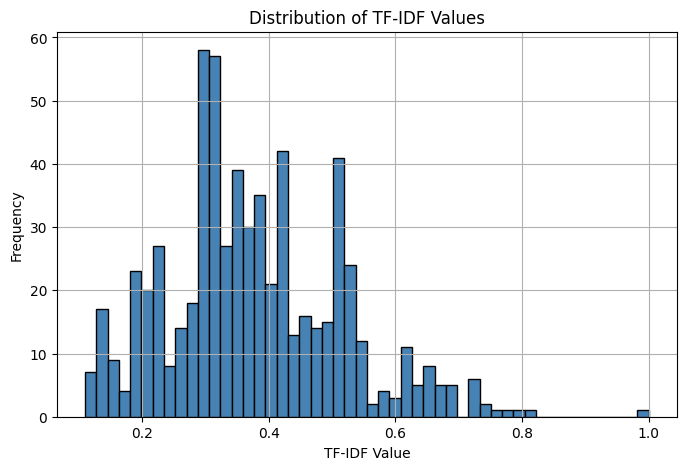

In [109]:
plt.figure(figsize=(8, 5))
plt.hist(X_tfidf.data, bins=50, color='steelblue', edgecolor='black')
plt.title('Distribution of TF-IDF Values')
plt.xlabel('TF-IDF Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### 3.5.2 Visualize most frequent words by job title (first 5 jobs titles)

In [110]:
feature_names = vectorizer.get_feature_names_out()

for i in range(5):  # first 5 job titles
    row = X_tfidf[i].toarray().flatten()
    top_indices = row.argsort()[-3:][::-1]
    top_words = [(feature_names[idx], row[idx]) for idx in top_indices]
    print(f"\nTop TF-IDF terms for job title {i}:")
    for word, score in top_words:
        print(f"  {word}: {score:.4f}")


Top TF-IDF terms for job title 0:
  magna: 0.3210
  cum: 0.3210
  2019: 0.3210

Top TF-IDF terms for job title 1:
  english: 0.6667
  program: 0.3333
  epik: 0.3333

Top TF-IDF terms for job title 2:
  professional: 0.6563
  aspiring: 0.5207
  resources: 0.3881

Top TF-IDF terms for job title 3:
  ryan: 0.5150
  people: 0.5150
  development: 0.5150

Top TF-IDF terms for job title 4:
  member: 0.4232
  advisory: 0.4232
  bayar: 0.4232


----


### 4. Use Cosine Similarity for vector search


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

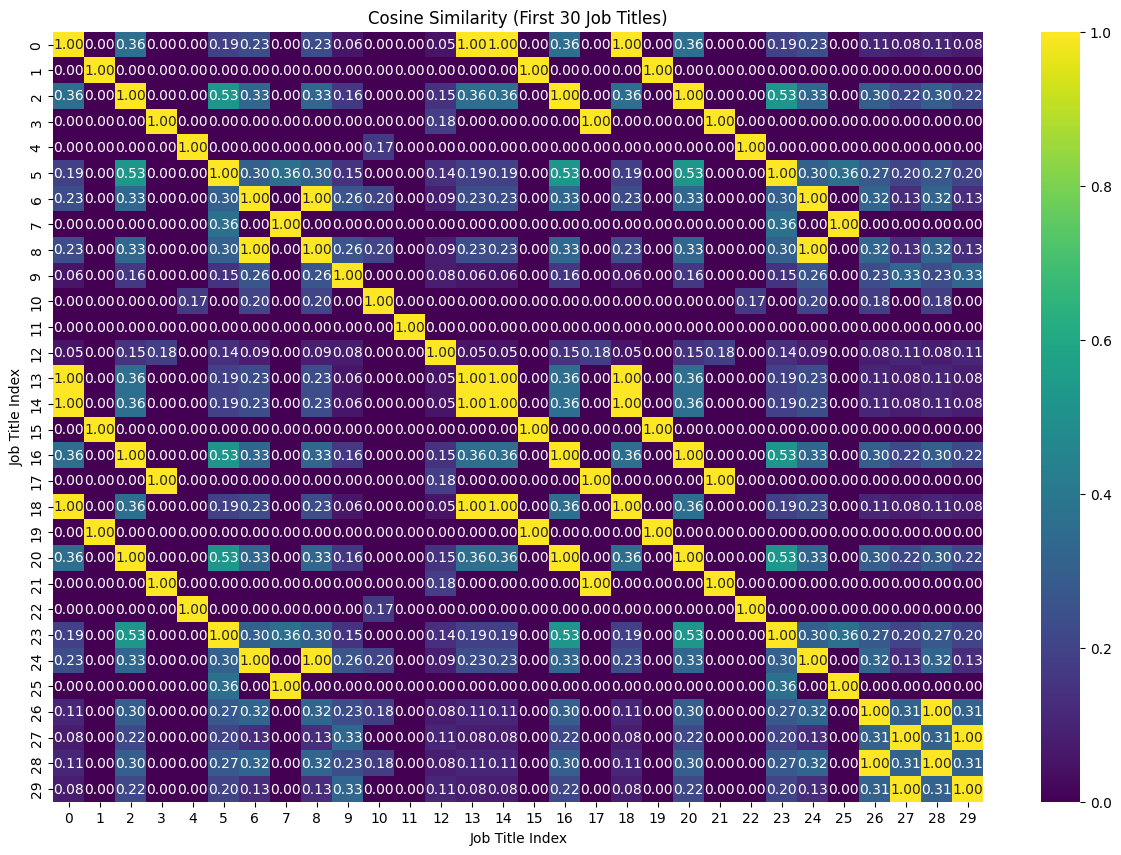

In [ ]:
# Compute cosine similarity matrix for the first 10 job titles
cosine_sim_matrix = cosine_similarity(X_tfidf)

# Plot heatmap
subset = 30  # first 20
plt.figure(figsize=(15, 10))
sns.heatmap(cosine_sim_matrix[:subset, :subset], annot=True, fmt=".2f", cmap="viridis") #, xticklabels=range(10), yticklabels=range(10))
plt.title(f"Cosine Similarity (First {subset} Job Titles)")
plt.xlabel("Job Title Index")
plt.ylabel("Job Title Index")
plt.show()

#### 4.1 **Extra:** Investigate the suspisious repeating pattern

We observed a repeating patern. We double check with the dataset and, effectively, the job title with index[0] is the same as indexes [13], [14] and [18].

We will check the whole picture, ploting the complete cosine similarity matrix (for all the job titles)

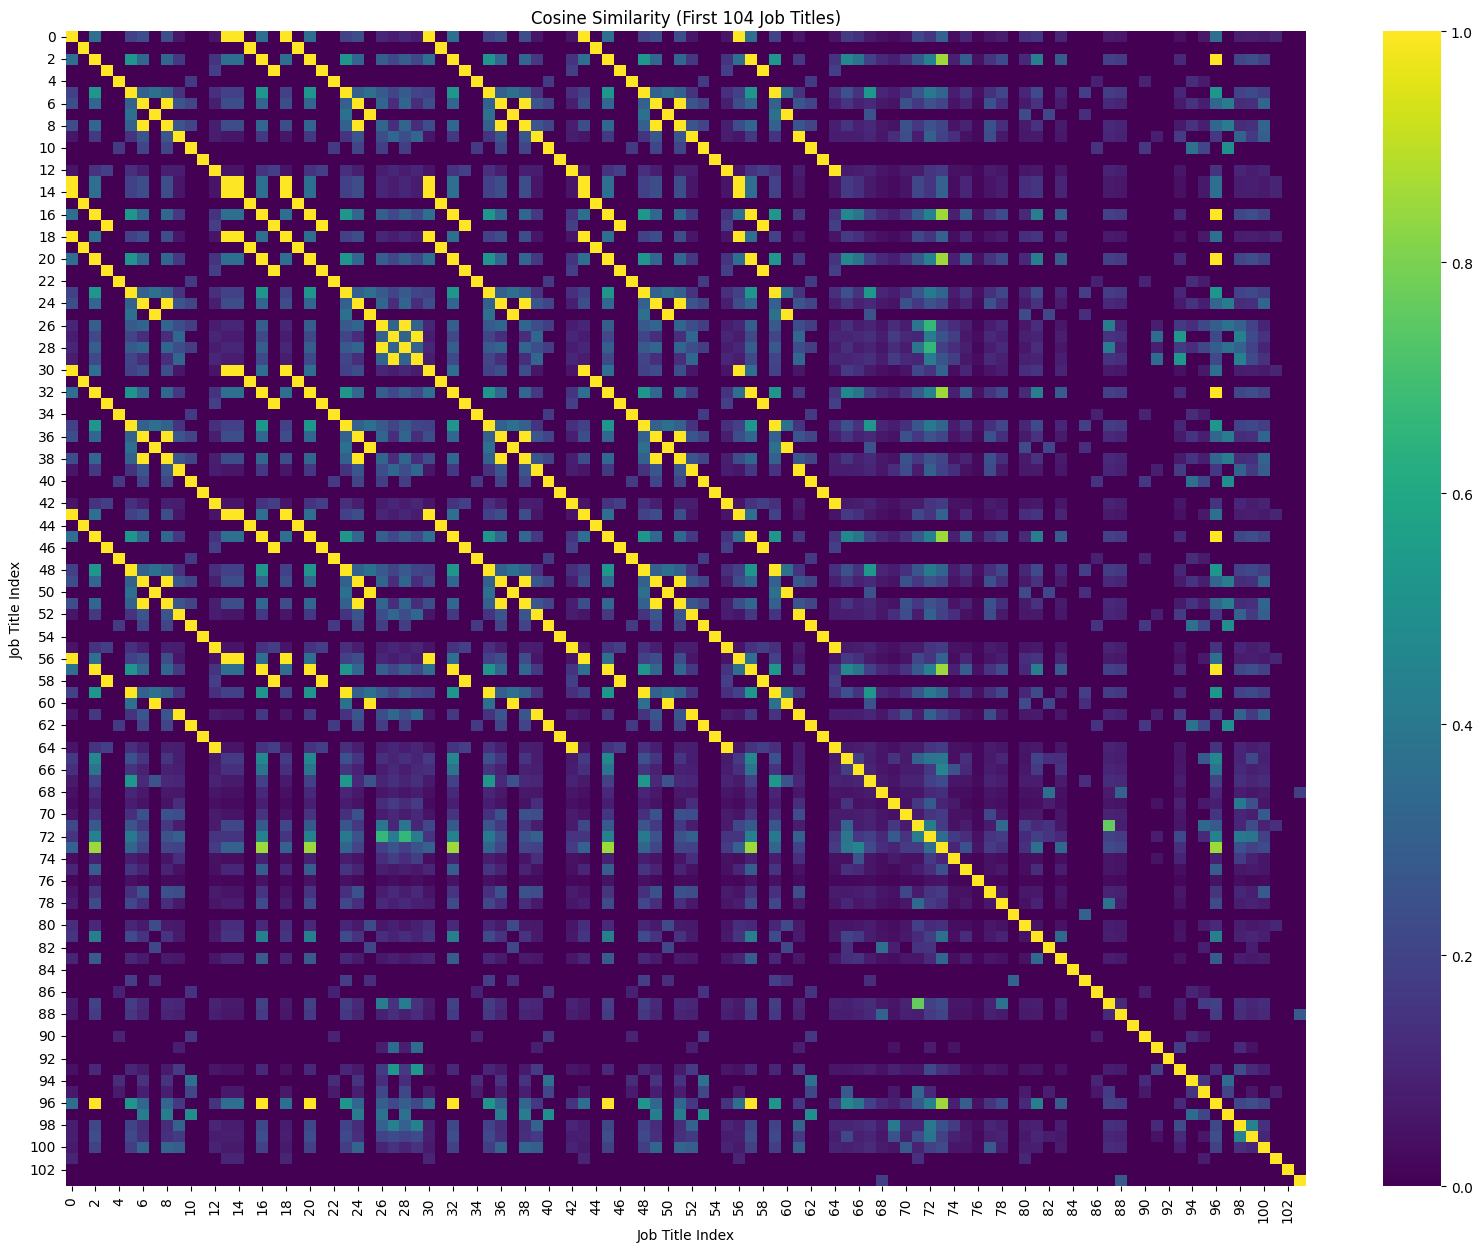

In [ ]:
# Compute cosine similarity matrix for the first 10 job titles
cosine_sim_matrix = cosine_similarity(X_tfidf)

# Plot heatmap
subset = 104
plt.figure(figsize=(20, 15))
sns.heatmap(cosine_sim_matrix[:subset, :subset], cmap="viridis")
plt.title(f"Cosine Similarity (First {subset} Job Titles)")
plt.xlabel("Job Title Index")
plt.ylabel("Job Title Index")
plt.show()


In [126]:
df['job_title'].value_counts().head(20)


job_title
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional       7
Aspiring Human Resources Professional                                                                          7
Student at Humber College and Aspiring Human Resources Generalist                                              7
People Development Coordinator at Ryan                                                                         6
Native English Teacher at EPIK (English Program in Korea)                                                      5
Aspiring Human Resources Specialist                                                                            5
HR Senior Specialist                                                                                           5
Advisory Board Member at Celal Bayar University                                                                4
Seeking Human Resources HRIS and Generalist Positions                                 

In [133]:
print(f'Number of job titles repeated: {sum(df['job_title'].value_counts() > 1)}\nNumber of job title repetions: {sum(df['job_title'].value_counts()[df['job_title'].value_counts() > 1])}')

Number of job titles repeated: 14
Number of job title repetions: 66


Observation: we found out that some of the job titles were repeated and even more than once

#### 4.2 Retrieve most similar Job Titles to "Data Scientist"

In [144]:
query = "Data Scientist"

# Tokenize, lowercase, and remove stop words/punctuation
query_to_tokens = nltk.word_tokenize(query.lower())
query_to_tokens = [t for t in tokens if t not in stop_words and t not in punctuations]
query_to_tokens



['data', 'scientist']

We will follow to different procedures: one, not using ML libs with tf-idf and matrix multiplications and other using Scikit-learn.


#### 4.2.1 Manual Calculations

##### 4.2.1.1 Encode the query

In [ ]:
# Encode the query
job_title_len = len(query_to_tokens)
word_counts = Counter(query_to_tokens)
df_query = np.zeros(len(vocab), dtype=float)   

# query's TF
for word, count in word_counts.items():
    if word in word_to_index:
        df_query[word_to_index[word]] = count / job_title_len
        

In [179]:
# apply the same smoothed IDF
query_tfidf = df_query * df_idf_smoothed

# normalize the query vector (L2 norm)
query_tfidf_norm = query_tfidf / np.linalg.norm(query_tfidf)

In [181]:
query_tfidf_norm

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Create the index_to_word 
index_to_word = { value: key for key, value in word_to_index.items()}

In [ ]:
non_zero_vocab_labels = ["" if value == 0 else index_to_word[idx] for idx, value in enumerate(df_query)]

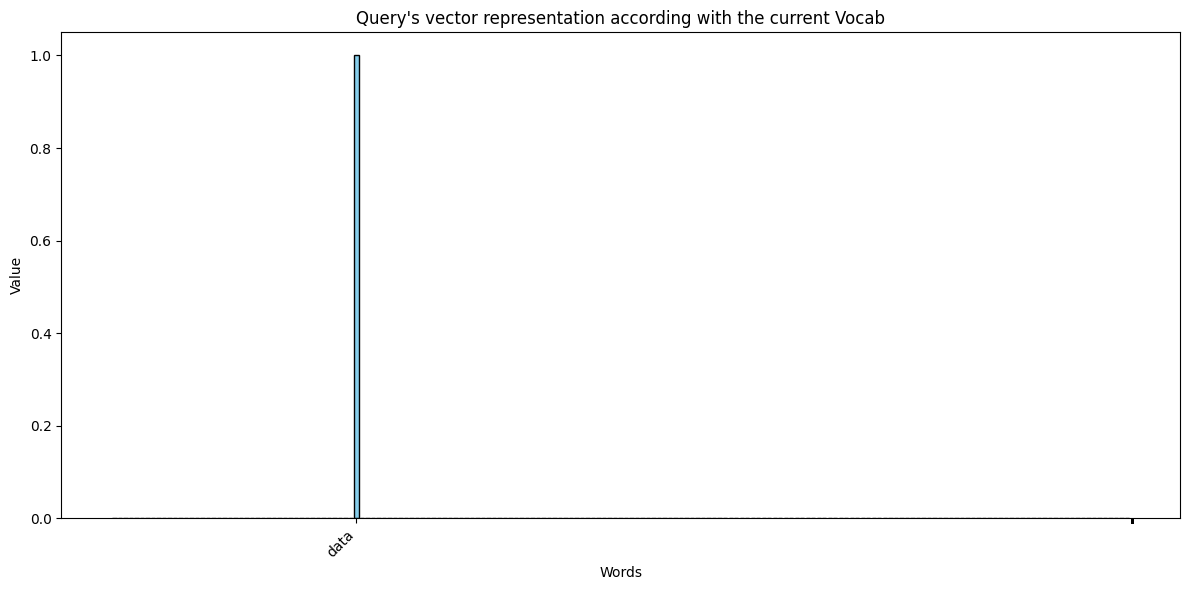

In [184]:
# Plot
plt.figure(figsize=(12, 6))
plt.bar(vocab, query_tfidf_norm, color='skyblue', edgecolor='black')
plt.xticks(ticks=non_zero_vocab_labels,labels=non_zero_vocab_labels, rotation=45, ha='right')
plt.title("Query's vector representation according with the current Vocab")
plt.xlabel("Words")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

**Observation**: Note that the vocab doesn't include the word 'scientist', it only includes the word 'data'.

##### 4.2.1.1 Compute cosine similarities

In [186]:
cosine_similarities = df_tfidf_smoothed_normalized @ query_tfidf_norm
cosine_similarities

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
99     0.0
100    0.0
101    0.0
102    0.0
103    0.0
Length: 104, dtype: float64

The query vector and each TF-IDF matrix's vectors are normalized, then we don't need to divide by the vectors norms.

In [187]:
top_n = 10
top_indices = cosine_similarities.argsort()[::-1][:top_n]

print(f"Top {top_n} similar job titles to '{query}':\n")
for idx in top_indices:
    print(f"{cosine_similarities[idx]:.4f} - {df['job_title'][idx]}")


Top 10 similar job titles to 'Data Scientist':

0.4057 - Information Systems Specialist and Programmer with a love for data and organization.
0.0000 - Director Of Administration at Excellence Logging
0.0000 - Business Intelligence and Analytics at Travelers
0.0000 - Always set them up for Success
0.0000 - Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis
0.0000 - Seeking Human Resources Position
0.0000 - Student
0.0000 - Human Resources Generalist at Loparex
0.0000 - Aspiring Human Resources Professional
0.0000 - Student at Indiana University Kokomo - Business Management - 
Retail Manager at Delphi Hardware and Paint


#### 4.2.2 Calculations using Scikit-learn

In [ ]:
query_tokens = nltk.word_tokenize(query.lower())
query_tokens = [t for t in query_tokens if t not in stop_words and t not in punctuations]
# Convert to string for TfidfVectorizer
query_processed = ' '.join(query_tokens)  

In [197]:
# transform query using the fitted TfidfVectorizer
query_vector = vectorizer.transform([query_processed])
query_vector.toarray().flatten()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# calculate the cosine similarities
cosine_sim_sklearn = cosine_similarity(query_vector, X_tfidf).flatten()
cosine_sim_sklearn

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [201]:
# list the top_k results using `cosine_sim_sklearn`
top_n = 10
top_indices = cosine_sim_sklearn.argsort()[::-1][:top_n]

print(f"Top {top_n} similar job titles to '{query}':\n")
for idx in top_indices:
    print(f"{cosine_sim_sklearn[idx]:.4f} - {df['job_title'][idx]}")


Top 10 similar job titles to 'Data Scientist':

0.4057 - Information Systems Specialist and Programmer with a love for data and organization.
0.0000 - Director Of Administration at Excellence Logging
0.0000 - Business Intelligence and Analytics at Travelers
0.0000 - Always set them up for Success
0.0000 - Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis
0.0000 - Seeking Human Resources Position
0.0000 - Student
0.0000 - Human Resources Generalist at Loparex
0.0000 - Aspiring Human Resources Professional
0.0000 - Student at Indiana University Kokomo - Business Management - 
Retail Manager at Delphi Hardware and Paint


#### 4.2.2.1 Compare calculations (Manual vs Scikit-learn)

In [204]:
comparison = np.allclose(cosine_similarities, cosine_sim_sklearn, atol=1e-5)
print(f'{"Manual and Scikit-learn implementations match (tolerance 1e-5)" if comparison else "Manual and Scikit-learn implementations DOESN'T match considering (tolerance 1e-5)."}')

Manual and Scikit-learn implementations match (tolerance 1e-5)
